In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import surrogate1 as sr1
import surrogate as sr
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import hr_restrict as hrr
import time
from torch.autograd.functional import jacobian
from torchdiffeq import odeint as odeint
from scipy.fft import fft, fftfreq
from scipy.linalg import dft
import seaborn as sns
device = torch.device("cpu")

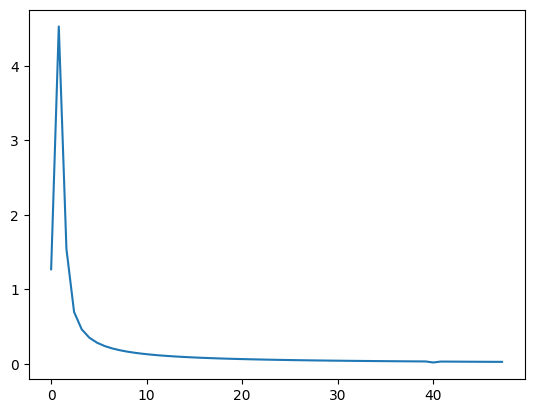

In [2]:
np.random.seed(28)
def get_func(n1, n2):
    n = np.random.randint(n2, size=n1)
    a_n = np.random.normal(size=n1)
    b_n = np.random.normal(size=n1)
    return lambda x: np.array([a_n[i]*np.cos(n_*x) + b_n[i]*np.sin(n_*x) for i, n_ in enumerate(n)]).sum(axis=0)

yr = get_func(3, 10)
x = np.linspace(-np.pi, np.pi, 1000)

pi2 = 2*np.pi
y = lambda x:  5*np.sin(pi2*1*x) + 0.1*np.sin(pi2*50*x) + 0.05*np.sin(pi2*40*x)
# Number of sample points
N = 1000
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N, endpoint=False)
yf = fft(y(x))
xf = fftfreq(N, T)[:60]
plt.plot(xf, 2.0/N * np.abs(yf[:60]))

Time taken by sample is 0.0086 seconds


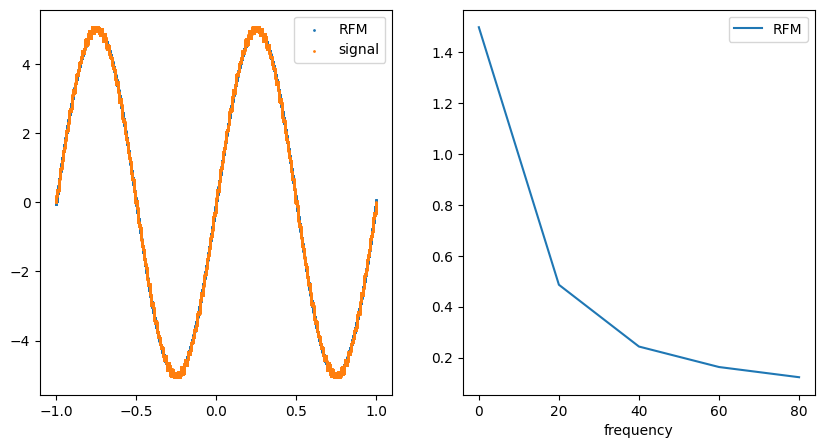

In [20]:
x = np.linspace(-1, 1, int(1e6))
fx = y(x)
N = 20000
idx = np.sort(np.random.choice(len(x), size=N))
train_x = x[idx].reshape(1, -1)
train_y = fx[idx].reshape(1, -1)

sampler = hrr.GoodRowSampler(0.4, 3.5, train_x)
D_r=300
beta = 4e-9
# random feature map
Wb = sampler.sample(D_r)
rf = sr.SurrogateModel_LR(D=3, D_r=D_r, W_in_fn=Wb[:, :-1], b_in_fn=Wb[:, -1])
rf.compute_W_xy(train_x, train_y, beta)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

rf_y = rf.forecast_m(train_x).flatten()
ax1.scatter(train_x.flatten(), rf_y, s=1, label='RFM')
ax1.scatter(train_x.flatten(), train_y.flatten(), s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
rf_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
rf_y = rf.forecast_m(rf_x).flatten()
yf = fft(rf_y)#fft(y(rf_x.flatten()))
xf = fftfreq(N, T)[:N//10]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//10]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

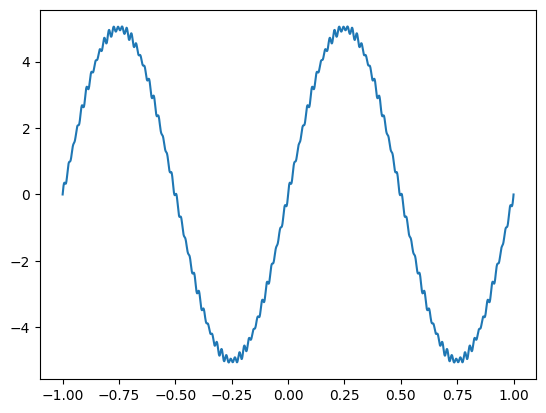

In [10]:
plt.plot(x, y(x))

In [16]:
network = srnn.SurrogateModel_NN(D=1, D_r=300, save_folder='../data/func-approx')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.init_with_rf_xy(0.4, 3.5, beta, train_x, train_y, [D_r-int(0*D_r/2), 0, int(0*D_r/2)])
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=5000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=True, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 6.915506 time: 0.0114 lr: 0.000010,  change: nan%
step: 100 loss: 7.680358 time: 0.5783 lr: 0.000010,  change: 11.06%
step: 200 loss: 7.001370 time: 0.9827 lr: 0.000010,  change: 1.24%
step: 300 loss: 7.000360 time: 1.3858 lr: 0.000010,  change: 1.23%
step: 400 loss: 6.751646 time: 1.7855 lr: 0.000010,  change: -2.37%
step: 500 loss: 8.254248 time: 2.1263 lr: 0.000010,  change: 22.26%
step: 600 loss: 9.294079 time: 2.5257 lr: 0.000010,  change: 37.66%
step: 700 loss: 10.154012 time: 2.9329 lr: 0.000010,  change: 50.39%
step: 800 loss: 12.868781 time: 3.3465 lr: 0.000010,  change: 90.60%
step: 900 loss: 7.189385 time: 3.7454 lr: 0.000010,  change: 6.48%
step: 1000 loss: 8.047695 time: 4.1456 lr: 0.000010,  change: 19.20%
step: 1100 loss: 11.112393 time: 4.5467 lr: 0.000010,  change: 64.59%
step: 1200 loss: 11.575140 time: 4.9443 lr: 0.000010,  change: 71.44%
step: 1300 loss: 7.561650 time: 5.3426 lr: 0.000010,  change: 12.00%
step: 1400 loss: 7.565857 time: 5.7410 lr: 0.00

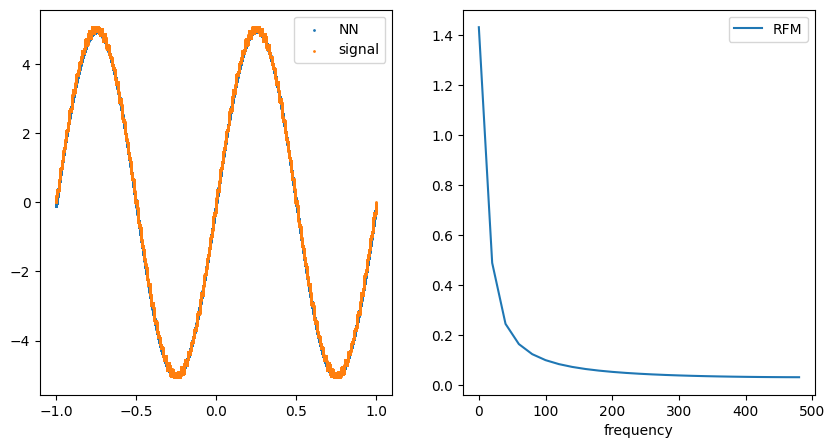

In [17]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [7]:
network = srnn.SurrogateModel_NN_multi(D=1, D_r=300, save_folder='../data/func-approx-multi')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=4e-9, learning_rate=1e-4, steps=1000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=True, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 12448.386214 time: 0.0336 lr: 0.000100,  change: nan%
step: 100 loss: 10471.104475 time: 1.4963 lr: 0.000100,  change: -15.88%
step: 200 loss: 7589.324126 time: 2.9319 lr: 0.000100,  change: -27.52%
step: 300 loss: 769.440035 time: 4.3741 lr: 0.000100,  change: -89.86%
step: 400 loss: 183.684398 time: 5.8167 lr: 0.000100,  change: -76.13%
step: 500 loss: 41.375507 time: 7.2617 lr: 0.000100,  change: -77.47%
step: 600 loss: 17.258717 time: 8.7085 lr: 0.000100,  change: -58.29%
step: 700 loss: 8.518849 time: 10.1557 lr: 0.000100,  change: -50.64%
step: 800 loss: 7.222064 time: 11.6106 lr: 0.000100,  change: -15.22%
step: 900 loss: 9.857649 time: 13.0716 lr: 0.000100,  change: 36.49%
Time taken by learn_xy is 14.5225 seconds


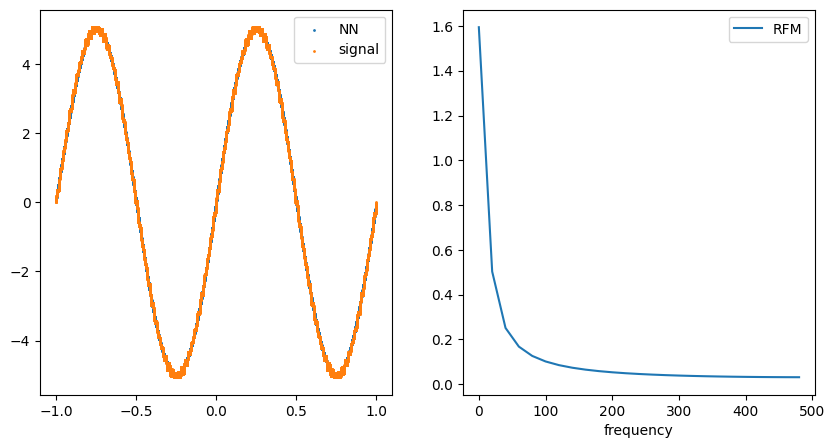

In [8]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [10]:
rf.final_loss

162.8976755496692

In [9]:
network.loss_fn(torch.from_numpy(train_x.T), torch.from_numpy(train_y.T), beta)

tensor(137.9317, grad_fn=<AddBackward0>)

In [10]:
rf.final_loss

162.8976755496692

In [12]:
network = srnn.SurrogateModel_NN_bn(D=1, D_r=300, save_folder='../data/func-approx-bn')
log_interval = 100
save_interval = 1000
update_frequency = 100
min_change = (1-0.01)**(1./log_interval) - 1.
network.learn_xy(train_x, train_y, beta=0., learning_rate=1e-5, steps=20000, batch_size=1000,\
                 max_delta=0.1, min_change=min_change, constant_rate=True, update_frequency=update_frequency, mode='simple-random')

step: 0 loss: 13817.556733 time: 0.0161 lr: 0.000010,  change: nan%
step: 100 loss: 13105.678073 time: 0.5127 lr: 0.000010,  change: -5.15%
step: 200 loss: 12673.975356 time: 0.9831 lr: 0.000010,  change: -3.29%
step: 300 loss: 12680.900071 time: 1.4582 lr: 0.000010,  change: 0.05%
step: 400 loss: 11914.610120 time: 1.9315 lr: 0.000010,  change: -5.99%
step: 500 loss: 12117.415174 time: 2.4017 lr: 0.000010,  change: 1.70%
step: 600 loss: 11753.447090 time: 2.8728 lr: 0.000010,  change: -1.35%
step: 700 loss: 11417.049513 time: 3.3421 lr: 0.000010,  change: -2.86%
step: 800 loss: 11536.787606 time: 3.8105 lr: 0.000010,  change: 1.05%
step: 900 loss: 11321.121973 time: 4.2941 lr: 0.000010,  change: -0.84%
step: 1000 loss: 11591.182736 time: 4.7677 lr: 0.000010,  change: 2.39%
step: 1100 loss: 10858.811354 time: 5.2407 lr: 0.000010,  change: -4.08%
step: 1200 loss: 11116.557716 time: 5.7137 lr: 0.000010,  change: 2.37%
step: 1300 loss: 10938.988578 time: 6.1850 lr: 0.000010,  change: 0.74

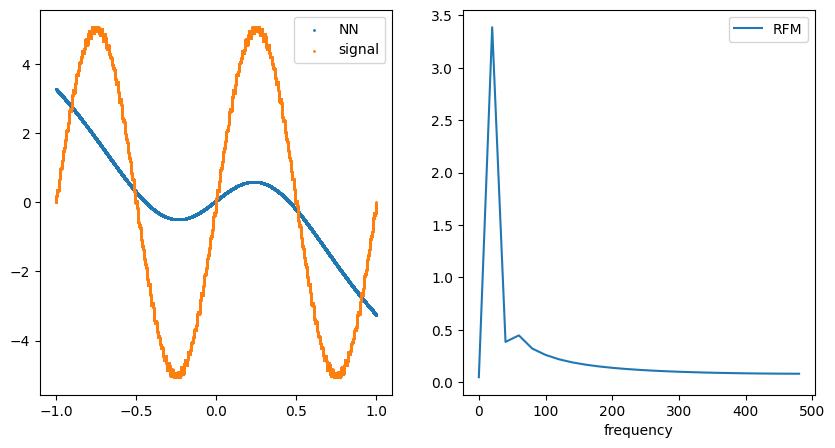

In [13]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

network_y = network.net(torch.from_numpy(train_x.T)).detach().numpy().flatten()
ax1.scatter(train_x.flatten(), network_y, s=1, label='NN')
ax1.scatter(train_x.flatten(), train_y, s=1, label='signal')
ax1.legend()
T = 1/1000
N = 50
network_x = np.linspace(0.0, N*T, N, endpoint=False).reshape(1, -1)
network_y = network.net(torch.from_numpy(network_x.T)).detach().numpy().flatten()
yf = fft(network_y)#fft(y(network_x.flatten()))
xf = fftfreq(N, T)[:N//2]
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='RFM')
ax2.set_xlabel('frequency')
ax2.legend()

In [24]:
repo = '..'
Rossler_data_folder = '{}/data/Rossler-trajectories'.format(repo)
train = np.load('{}/train_20000.npy'.format(Rossler_data_folder))
rs = hrr.GoodRowSampler(0.4, 3.5, train)
Wb = rs.sample(300)
test = np.load('{}/test.npy'.format(Rossler_data_folder))[:, :800, :]
rf = sr.SurrogateModel_LR(D=3, D_r=300, W_in_fn=Wb[:, :-1], b_in_fn=Wb[:, -1])
rf.compute_W(train, 4e-5)
a, b, c, d = rf.compute_forecast_time(test[:500], 0.05, 0.02, Lyapunov_time=1/0.071)

Time taken by sample is 0.0131 seconds


(array([  0.,   0.,   0.,   0.,   0., 500.,   0.,   0.,   0.,   0.]),
 array([0.636, 0.736, 0.836, 0.936, 1.036, 1.136, 1.236, 1.336, 1.436,
        1.536, 1.636]),
 <BarContainer object of 10 artists>)

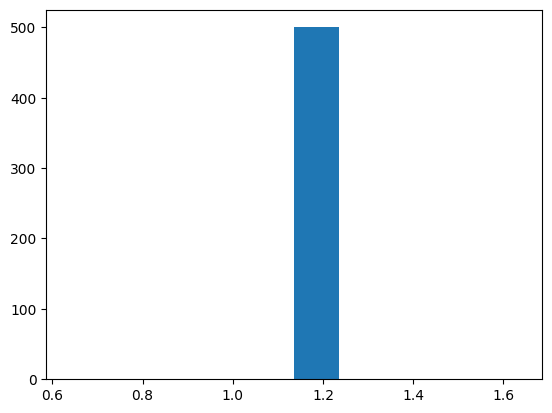

In [25]:
plt.hist(a)

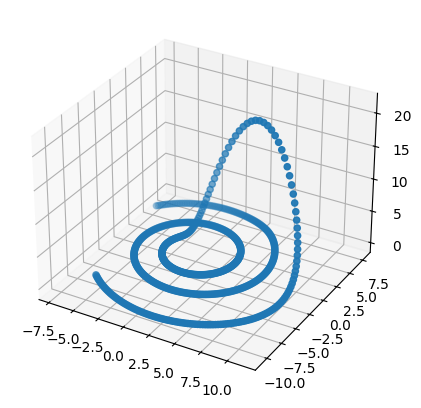

In [50]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
t = test[499]
ax.scatter(t[0, :], t[1, :], t[2 ,:])

In [21]:
800*0.71

568.0

In [48]:
repo = '..'
L63_data_folder = '{}/data/L63-trajectories'.format(repo)
train = np.load('{}/train.npy'.format(L63_data_folder))[:20000]
rs = hrr.GoodRowSampler(0.4, 3.5, train)
Wb = rs.sample(300)
test = np.load('{}/test.npy'.format(L63_data_folder))[:, :800, :]
rf = sr.SurrogateModel_LR(D=3, D_r=300, W_in_fn=Wb[:, :-1], b_in_fn=Wb[:, -1])
rf.compute_W(train, 4e-5)
a, b, c, d = rf.compute_forecast_time(test[:500], 0.05, 0.02, Lyapunov_time=1/0.91)

Time taken by sample is 0.0072 seconds


(array([410.,   0.,  80.,   0.,   6.,   0.,   2.,   0.,   1.,   1.]),
 array([0.0182, 0.0273, 0.0364, 0.0455, 0.0546, 0.0637, 0.0728, 0.0819,
        0.091 , 0.1001, 0.1092]),
 <BarContainer object of 10 artists>)

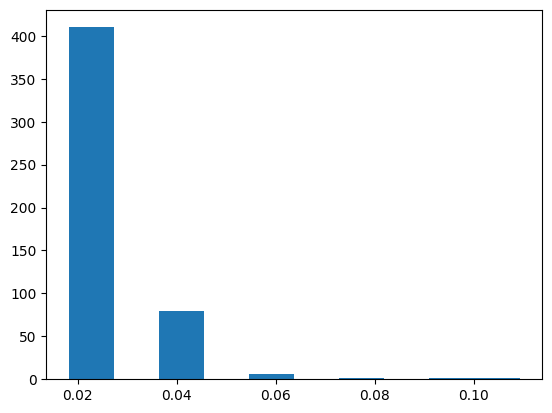

In [49]:
plt.hist(a)

In [ ]:
test = np.load('{}/test.npy'.format(L63_data_folder))[:, :800, :]
plt.scatter(test[0, :, :], test[])